# Lotka Volterra

In [1]:
#%%
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
from loss_cal.tasks.lotka_volterra import LotkaVolterra
from loss_cal.costs import RevGaussCost
from loss_cal.utils.utils import load_data, atleast_2d_col
from loss_cal.predictor import train, build_nn

plot_config_file = "loss_cal/utils/.matplotlibrc"
seed = 0
torch.manual_seed(seed)

## Set Up

In [3]:
lv = LotkaVolterra(action_type="continuous")
lv.task_name

'lotka_volterra'

Prior and Simulator

In [4]:
prior = lv.get_prior()
simulator = lv.get_simulator()

In [5]:
print(lv.dim_data,              # dimensionality data, here: 20
      lv.dim_parameters,        # dimensionality parameters, here: 4
      lv.num_observations)      # number of different observations x_o available, here: 10

20 4 10


10 observations provided by the sbibm task

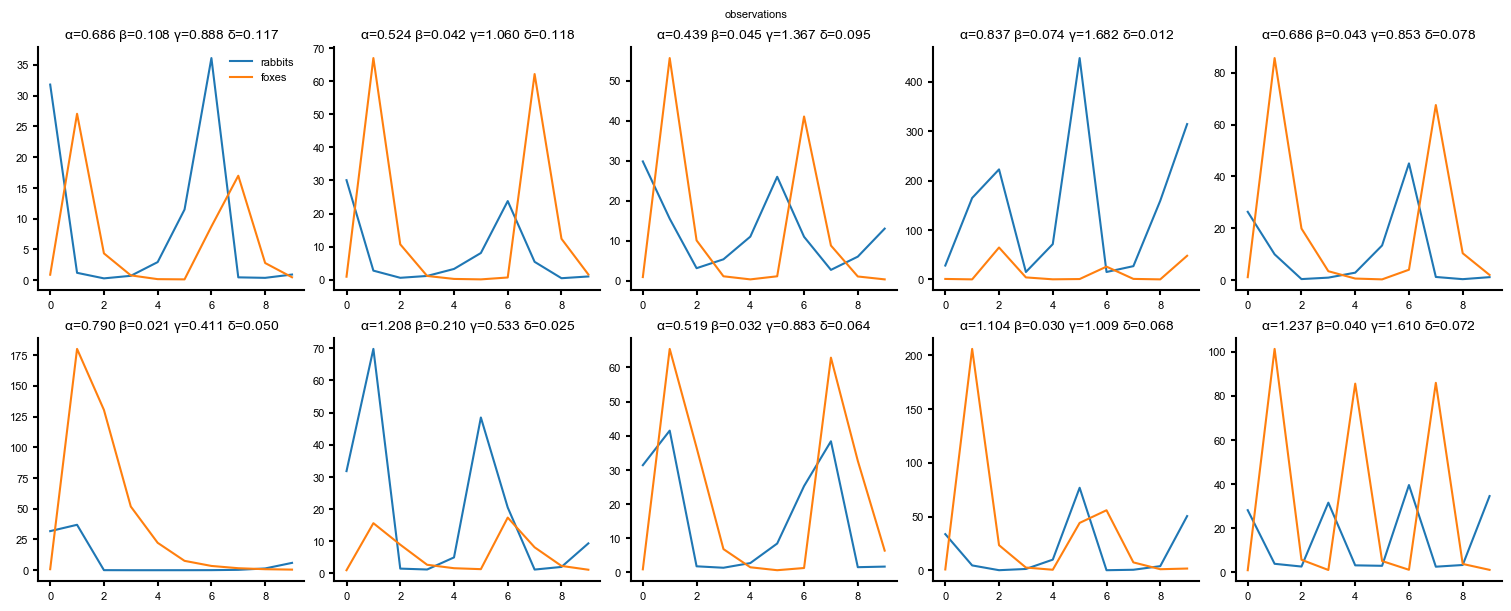

In [6]:
with mpl.rc_context(fname=plot_config_file):
    fig, axes = lv.plot_observations(2,5)
    plt.show()  

Prior

In [7]:
lv.prior_params

{'loc': tensor([-0.1250, -3.0000, -0.1250, -3.0000]),
 'scale': tensor([0.5000, 0.5000, 0.5000, 0.5000])}

()

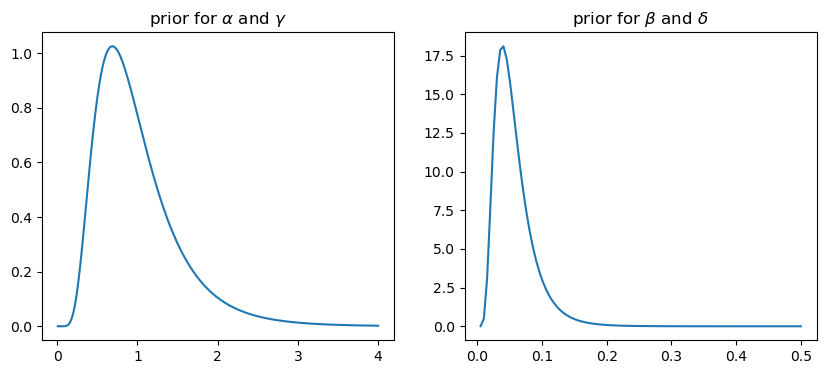

In [8]:
# priors defined as Log Normal with 
mu_p1 = -0.125
mu_p2 = -3.0
sigma_p = 0.5

ths1  = torch.linspace(0,4, 500)
ths2  = torch.linspace(0,0.5, 100)
log_normal1 = torch.distributions.LogNormal(mu_p1, sigma_p)
log_normal2 = torch.distributions.LogNormal(mu_p2, sigma_p)

fig, axes = plt.subplots(1,2,figsize=(10,4))
axes[0].plot(ths1, torch.exp(log_normal1.log_prob(ths1)))
axes[0].set_title(r'prior for $\alpha$ and $\gamma$')
axes[1].plot(ths2, torch.exp(log_normal2.log_prob(ths2)))
axes[1].set_title(r'prior for $\beta$ and $\delta$')
plt.show
()

In [9]:
log_normal1.icdf(torch.Tensor([0.999])), log_normal2.icdf(torch.Tensor([0.999]))

(tensor([4.1376]), tensor([0.2334]))

Posterior

Only 10 reference samples given

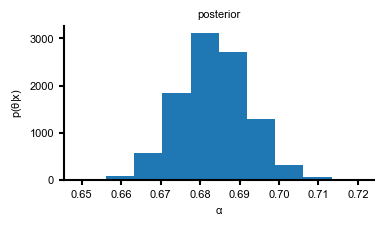

In [10]:
p = 0
n_obs = 1
posterior_evals = lv.get_reference_samples(n_obs)[:, p]
with mpl.rc_context(fname=plot_config_file):
    fig, ax = plt.subplots(1, 1, figsize=(4, 2))
    ax.hist(posterior_evals)
    ax.set_xlabel(rf"{lv.parameter_names[p]}")
    ax.set_ylabel(r"$p(\theta|x)$")
    ax.set_title("posterior")
    plt.show()

## Continuous Actions

### Decision Task

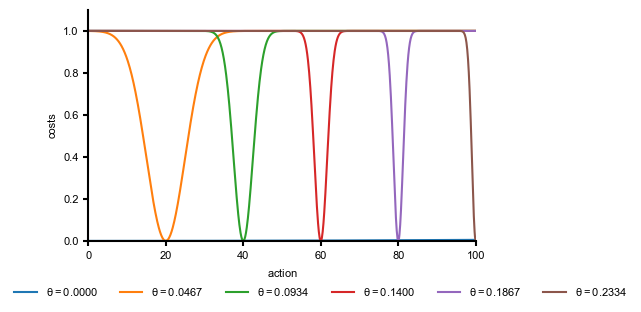

In [31]:
factor = 2
exponential = 2
param = 1
parameter_range = (lv.param_high - lv.param_low)[param].item()
cost_fn = RevGaussCost(
    parameter_range=parameter_range, ## FIXED PARAMETER
    action_range=lv.action_high - lv.action_low,
    factor=factor,
    exponential=exponential
)

with mpl.rc_context(fname=plot_config_file):
    resolution = 1000
    actions = torch.arange(lv.action_low, lv.action_high, (lv.action_high - lv.action_low) / resolution)

    fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    for theta in torch.arange(lv.param_low[param].item(), lv.param_high[param].item() + 0.01, parameter_range/5):
        ax.plot(actions, cost_fn(theta, actions), label=rf"$\theta={theta:.4f}$")

    ax.set_xlabel(r"$action$")
    ax.set_ylabel("costs")
    ax.set_xlim(lv.action_low, lv.action_high)
    ax.set_ylim(0, 1.1)
    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.6, -0.15),
        fancybox=True,
        shadow=True,
        ncol=6,
    )
    # plt.savefig("./results/continuous/toy_example/fig_cost_fct.pdf")
    plt.show()

In [32]:
x_reference = torch.vstack([lv.get_observation(i) for i in range(1,11)])
post_reference = torch.stack([lv.get_reference_samples(i) for i in range(1,11)])
param_reference = torch.vstack([lv.get_true_parameters(i) for i in range(1,11)])

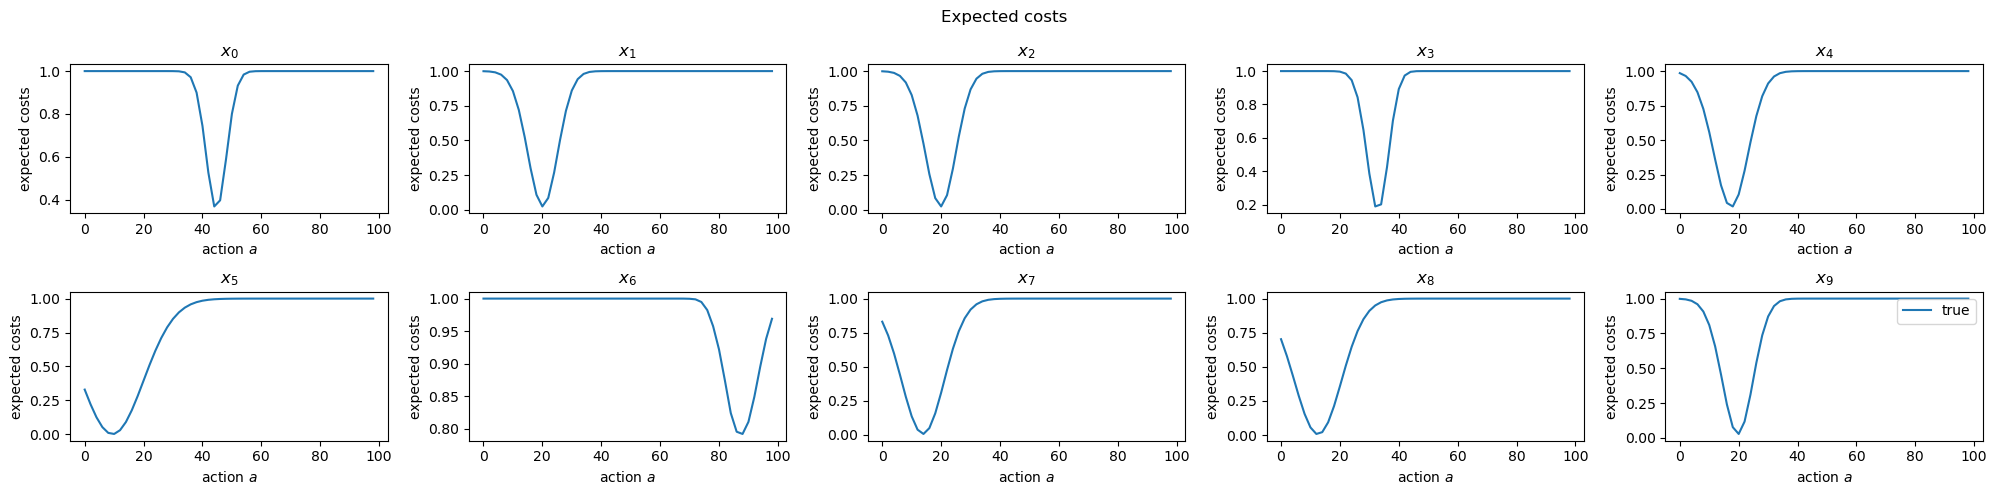

In [33]:
a_grid = torch.arange(lv.action_low, lv.action_high, 2.0)
expected_costs_post = []

plt.figure(figsize=(20, 5))
for i, x in enumerate(x_reference):
    plt.subplot(2, 5, i + 1 % 5)

    expected_posterior_costs = torch.tensor(
        [lv.expected_posterior_costs(x=i + 1, a=a, param=param, cost_fn=cost_fn) for a in a_grid]
    )
    expected_costs_post.append(expected_posterior_costs)
  
    plt.plot(a_grid, expected_posterior_costs, label="true")
    plt.xlabel(r"action $a$")
    plt.ylabel("expected costs")
    plt.title(rf"$x_{i}$")
plt.suptitle("Expected costs")
plt.tight_layout()
plt.legend()
plt.show()

### Actions

In [14]:
actions = lv.actions

### Load data

In [15]:
n_train = 10_000#50_000
n_test = 10_000

theta_train, x_train, theta_val, x_val, theta_test, x_test = load_data("lotka_volterra")
theta_train_full = theta_train[:n_train]
theta_train = theta_train[:n_train, param:param+1]
x_train = x_train[:n_train]
theta_val = theta_val[:n_test, param:param+1]
x_val = x_val[:n_test]
theta_test = theta_test[:n_test, param:param+1]
x_test = x_test[:n_test]

Load data from './data/lotka_volterra', device = cpu.


In [16]:
print(f"N_train = {theta_train.shape[0]}, N_val = {theta_val.shape[0]}, N_test = {theta_test.shape[0]}")

N_train = 10000, N_val = 10000, N_test = 10000


### Train a neural network to predict expected costs

In [20]:
nn = build_nn(
    "fc",
    x_train=x_train,
    action_train=lv.actions.sample(n=x_train.shape[0]),
    hidden_dims=[50,50,50],
    output_dim=1,
    activation=torch.nn.ReLU(),
    output_transform=torch.nn.Sigmoid(),
    seed = seed
)
print(nn, end="\n-----\n")

nn, train_loss, val_loss = train(
    model= nn,
    x_train=x_train,
    theta_train=theta_train,
    cost_fn=cost_fn,
    x_val=x_val,
    theta_val=theta_val,
    actions = lv.actions,
    learning_rate=1e-3,
    model_dir="./results/lotka_volterra/continuous/notebook",
    max_num_epochs=800,
    stop_after_epochs=30,
    seed = seed, 
    save_sampled_actions=True
)

FeedforwardNN(
  (standardize_layer): Standardize()
  (input_layer): Linear(in_features=21, out_features=50, bias=True)
  (hidden_layers): ModuleList(
    (0-1): 2 x Linear(in_features=50, out_features=50, bias=True)
  )
  (final_layer): Linear(in_features=50, out_features=1, bias=True)
  (activation): ReLU()
  (output_transform): Sigmoid()
)
-----
Subdirectory 'checkpoints' already exists. Delete first if wanted.
Converged after 195 epochs. train_loss = 0.01070968	 last_improvement = 30


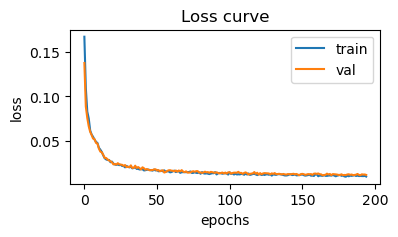

tensor(0.0119)


In [21]:
fig, ax = plt.subplots(1,1, figsize = (4,2))
ax.plot(train_loss, label="train")
ax.plot(val_loss, label = "val")
ax.set_title("Loss curve"); ax.set_xlabel("epochs"); ax.set_ylabel("loss")
ax.legend()
plt.show()
print(val_loss.min())

### Evaluate model

In [22]:
x_reference = torch.vstack([lv.get_observation(i) for i in range(1,11)])
post_reference = torch.stack([lv.get_reference_samples(i) for i in range(1,11)])[:,:,param]
param_reference = torch.vstack([lv.get_true_parameters(i) for i in range(1,11)])[:,param]

Check predictions on the reference observations

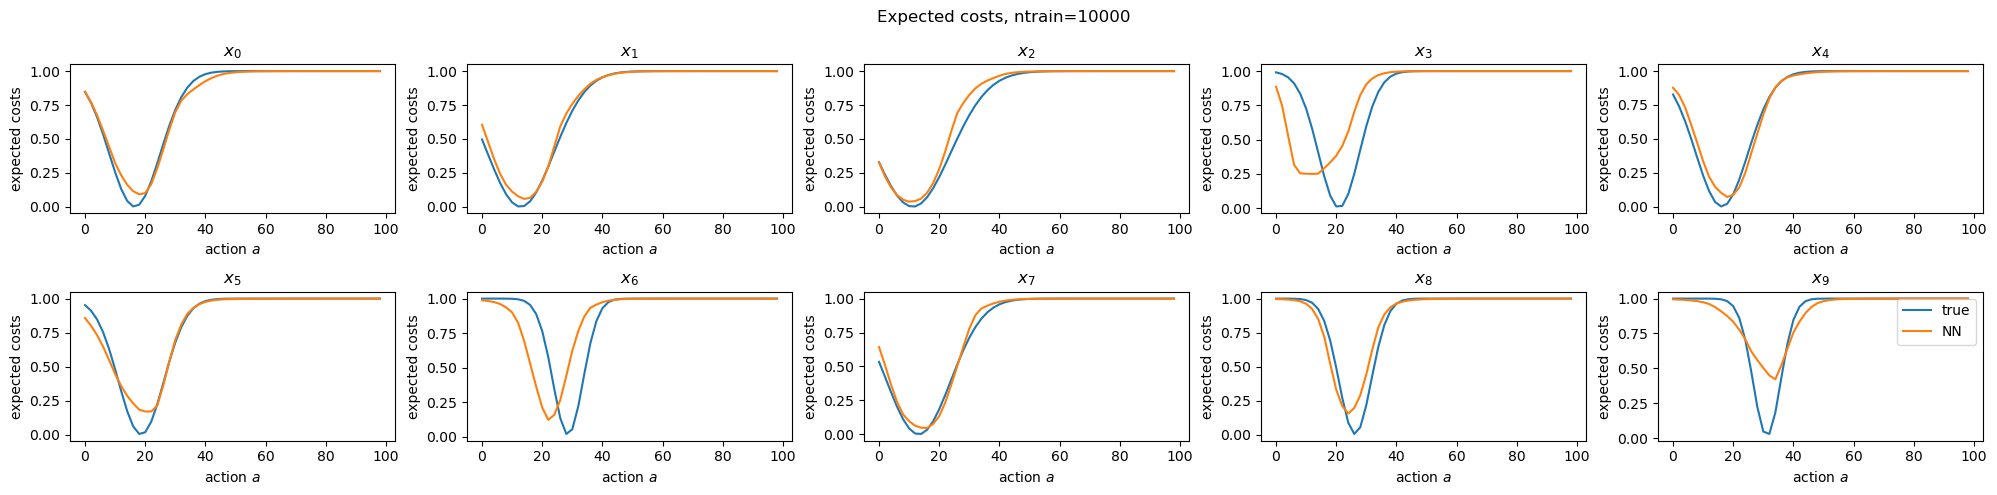

In [23]:
a_grid = torch.arange(lv.action_low, lv.action_high, 2.0)
expected_costs_post = []
expected_costs_nn = []

plt.figure(figsize=(20, 5))
for i, x in enumerate(x_reference):
    plt.subplot(2, 5, i + 1 % 5)

    expected_posterior_costs = torch.tensor(
        [lv.expected_posterior_costs(x=i + 1, a=a, param=param, cost_fn=cost_fn) for a in a_grid]
    )
    predicted_costs = torch.tensor([nn(x.unsqueeze(0), atleast_2d_col(a)).detach() for a in a_grid])
    expected_costs_post.append(expected_posterior_costs)
    expected_costs_nn.append(predicted_costs)

    plt.plot(a_grid, expected_posterior_costs, label="true")
    plt.plot(a_grid, predicted_costs, label="NN")
    plt.xlabel(r"action $a$")
    plt.ylabel("expected costs")
    plt.title(rf"$x_{i}$")
plt.suptitle(f"Expected costs, ntrain={n_train}")
plt.tight_layout()
plt.legend()
# plt.savefig("./results/continuous/toy_example/fig_expected_costs.pdf")
plt.show()

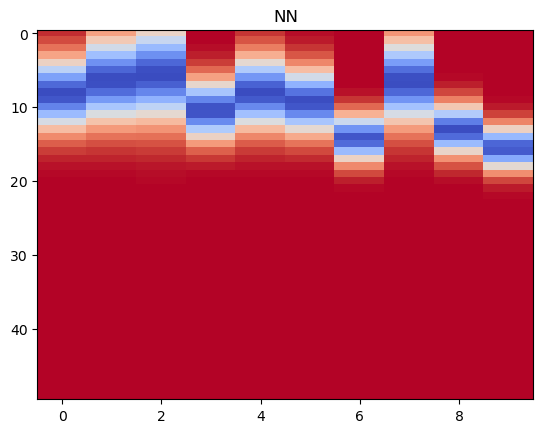

In [ ]:
plt.title("NN")
plt.imshow(torch.stack(expected_costs_post).T, aspect="auto", cmap="coolwarm")
plt.show()

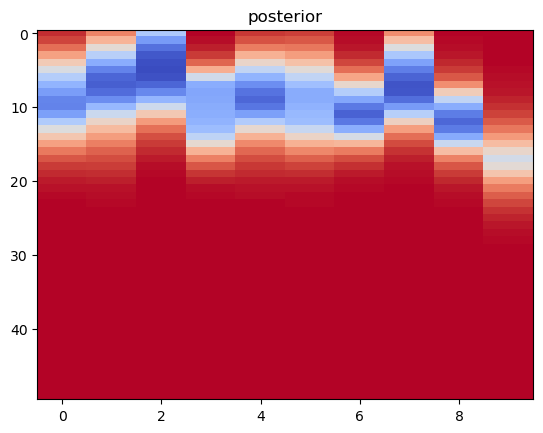

In [ ]:
plt.title("posterior")
plt.imshow(torch.stack(expected_costs_nn).T, aspect="auto", cmap="coolwarm")
plt.show()

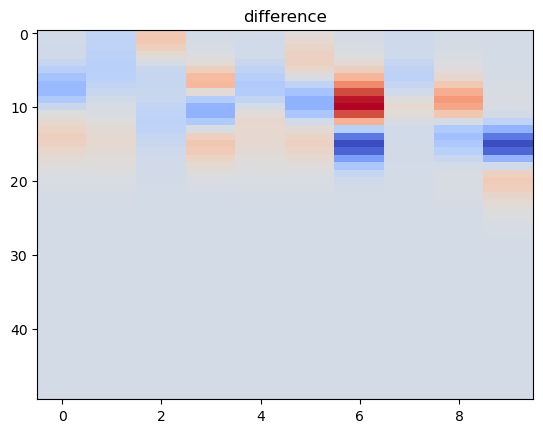

In [ ]:
plt.title("difference")
plt.imshow(torch.stack(expected_costs_post).T - torch.stack(expected_costs_nn).T, aspect="auto", cmap="coolwarm")
plt.show()

#### Trying things out

Find closest point in training data

In [ ]:
# clostest training data point (L2 dist)
close_x_train = x_train[((x_train - x_reference[0:1])**2).mean(dim=1).argmin()].unsqueeze(0)

print('x_ref:', x_reference[0:1])
print('clostest:', close_x_train)


x_ref: tensor([[31.7833,  1.1971,  0.2970,  0.7115,  2.9416, 11.4826, 36.0904,  0.4623,
          0.3808,  0.9174,  0.8910, 27.0399,  4.3562,  0.7844,  0.1710,  0.1326,
          8.7270, 16.9725,  2.7902,  0.4757]])
clostest: tensor([[31.2566,  1.6532,  0.1806,  0.4338,  1.5970,  9.3764, 32.6576,  0.3408,
          0.2208,  0.7302,  1.0347, 31.9709,  6.8161,  1.5901,  0.3269,  0.2224,
          8.2629, 18.3258,  4.1908,  1.0768]])


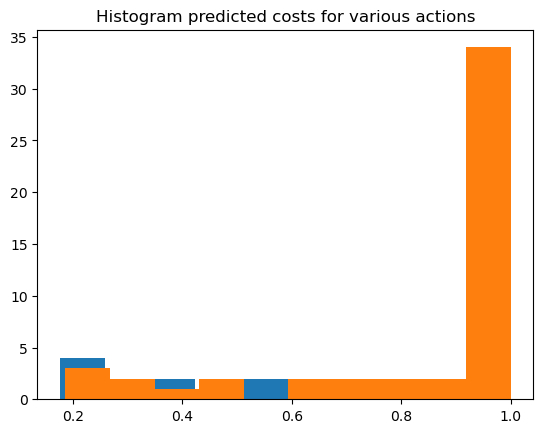

In [ ]:
plt.title("Histogram predicted costs for various actions")
plt.hist(torch.Tensor([nn(x_reference[0:1], a.reshape(-1,1)).detach() for a in a_grid]))
plt.hist(torch.Tensor([nn(close_x_train, a.reshape(-1,1)).detach() for a in a_grid]))
plt.show()